<small><i>This notebook was originally put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2014. [Peter Prettenhofer](https://github.com/pprett) adapted it for PyCon Ukraine 2014. Source and license info is on [GitHub](https://github.com/pprett/sklearn_pycon2014/).</i></small>

# Supervised Learning In-Depth: SVMs and Tree Ensembles

There are many machine learning algorithms available; here we'll go into brief detail on two of the most common and interesting ones: **Support Vector Machines (SVM)** and **Tree Ensembles**.

By the end of this section you should:

- have an intuitive understanding of *Support Vector Machines*.
- understand how decision trees work
- understand how multiple decision trees are combined into *Random Forests* and *Boosting*

As before, we'll start by getting our notebook ready for interactive plotting:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


## Support Vector Machines

Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for **classification** or for **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

Let's show a quick example of support vector classification. First we need to create a dataset:

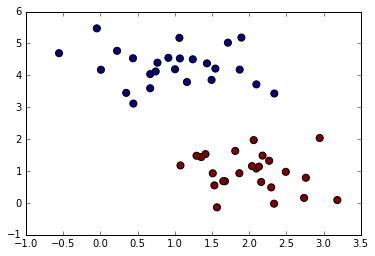

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

The goal in classification is to create a decision rule (aka *hypotheses*) that separates the red from the blue instances for new (unseen) data. Lets assume for now that we limit ourselves to a straight line as our decision rule.

Which inductive principle would you follow to select a decision rule?

### Inductive Principle

  1. Minimize error on the training set (aka *risk minimization*)
  2. Maximize *margin* between the separating line and the nearest data points.

The latter principle is called the *max-margin* classifier and was developed by Vladimir N. Vapnik and colleagues in the 1990s.

In [3]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [4]:
def plot_svc_decision_function(clf):
    """Plot the decision function for a 2D SVC"""
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [5]:
import warnings
warnings.filterwarnings('ignore')

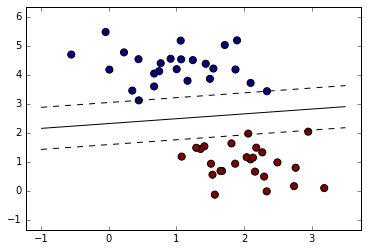

In [6]:

plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf);

Notice that the dashed lines touch a couple of the points: these points are known as the "support vectors", and are stored in the ``support_vectors_`` attribute of the classifier:

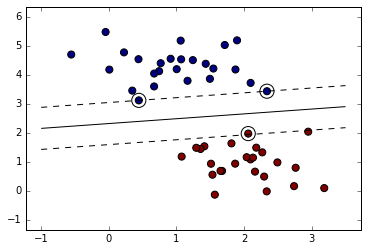

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none')

People often refer to the SVM as a stable classifier since you can make pertubations to your training data but unless the support vectors are not changed it won't have an effect on the hypothesis.

### Non-seperable case

What if the data cannot be separated by a straight line?

  * Kernel-trick
  * Soft-margin SVM
  
#### Kernel trick

The idea is to map your (non-seperable) data into a higher dimensional feature space in the hope that you can find a linear separator in that mapped space. This is very likely since there are many more degrees of freedom in high dimensional spaces. In general, any (linear) separator that you found in this mapped space is a non-linear separator in the original feature space.

The key advantage of the SVM is that certain mappings can be done implicitly trough similarity computations among data points  rather than making an explicit mapping into the higher dimensional space.
In scikit-learn you can use the ``kernel`` argument to specify the mapping.
The above example uses a ``'linear'`` kernel; it is also possible to use *radial basis function* (``'rbf'``) kernels as well as others.

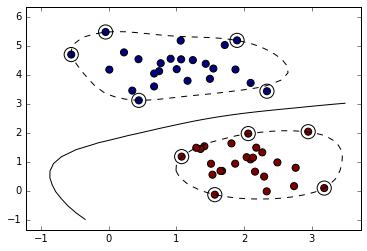

In [8]:
clf = SVC(kernel='rbf')
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

#### Soft-margin SVM

We can also relax the constraint that the line needs to separate our data perfectly and provide a budget for *margin violations* that we call the *complexity* parameter. The higher the parameter the less budget we have for violations and the "thinner" the separator gets. 

The complexity parameter ``C`` is a nuance parameter (or *hyperparameter*) that needs to be tuned for each problem. We will cover hyperparameter optimization later in the tutorial.

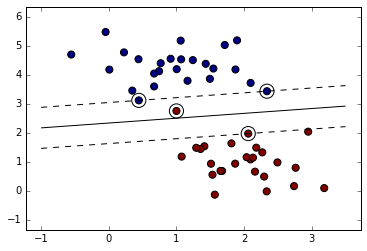

In [9]:
# add one data point on the opposite side of the hyperplane
X_prime, y_prime = np.r_[X, np.array([[1, 2.75]])], np.r_[y, 1]

plt.scatter(X_prime[:, 0], X_prime[:, 1], c=y_prime, s=50)
# set complexity budget to 1 (higher C will lead to a smaller margin)
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_prime, y_prime)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none')

The effect of the complexity parameter on the decision boundary seen interactively by running the ``fig_code/svm_gui.py`` script:

In [10]:
# %run fig_code/svm_gui.py

SVMs can also be applied to [regression problems](http://scikit-learn.org/stable/modules/svm.html#regression) -- and even [unsupervised problems](http://scikit-learn.org/stable/modules/svm.html#density-estimation-novelty-detection) -- but their main usage is in classification. 

With the advent of *deep learning*, SVMs lost most of their reputation that originated from the field of computer vision but (linear) Support Vector Machines are still one of the major work horses in machine learning.

We'll leave SVMs for the time being and take a look at another powerful classifier.

#### Quick Exercise

Do you think ``SVC`` and ``KNeighborsClassifier`` are related? If so, what are their similarites and what are the differences?

What does an SVM need to consider when predicting the label of a new instance? What is the runtime complexity at prediction time?

## Ensembles techniques

Ensemble, or mixtures of experts, combine multiple (weak) learners to create an even more accurate (strong) learner. In principal, these ensemble techniques can work with any weak learner but decision trees are the most popular choice so we limit ourselves to tree ensembles here. 

### Decision Trees

Here we'll explore a class of algorithms based on Decision trees. Decision trees at their root (Ha!) are extremely intuitive.  They encode a series of binary choices in a process that parallels how a person might classify things themselves, but using an information criterion to decide which question is most fruitful at each step.  Below we show an example of a decision tree that was built to predict the median house price for block census groups in California (1999 census) using features such as the median income in that area, the average house size, or the average number of occupants.

![foobar](images/decision_tree.png)

In [11]:
from sklearn.tree import DecisionTreeClassifier

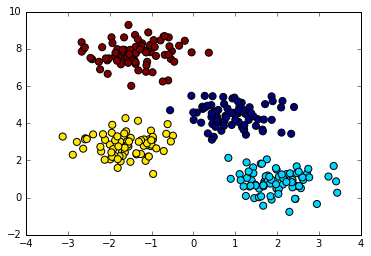

In [12]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

We'll start by defining a convenience function which allows us to plot the predicted value in the background:

In [13]:
def plot_estimator(estimator, X, y):
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.3)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

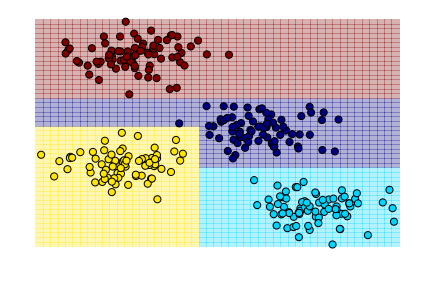

In [14]:
clf = DecisionTreeClassifier(max_depth=10)
plot_estimator(clf, X, y)

### Tree ensembles

One problem with decision trees is that they can end up **over-fitting** the data. They are such flexible models that, given a large depth, they can quickly memorize the inputs, which doesn't generalize well to previously unseen data. 

Nowadays, decision trees are hardly used in isolation but rather in so-called tree ensembles. These ensembles come in three flavors: **Bagging**, **RandomForest**, and **Boosting**.

#### Random Forests

[Bagging](http://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator) and [RandomForest](http://scikit-learn.org/stable/modules/ensemble.html#random-forests) are similar in the sense that they train a large number of trees in a randomized fashion and then average the prediction of those trees. Boosting, on the other hand, is quite different from the other two and will be discussed later.

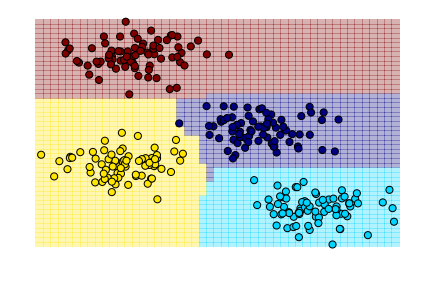

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_features='sqrt', random_state=0)
plot_estimator(clf, X, y)

It's difficult to see in this example, but for more complicated data, random forests can be a very powerful technique.

#### Boosting

Boosting differes from Bagging and RandomForest in that it learnes the ensemble in a sequential fashion: each member of the ensemble is an expert on the errors of its predecessor. On of the first boosting algorithms was **AdaBoost**, for adaptive boosting, developed by Y. Freund and R. Schapire. 

The algorithm proceedes in stages, at each stage we train a (shallow) decision tree to a re-weighted version of the original dataset. After we trained a tree we up-weight examples we got wrong and down-weight examples we got right. The next tree is then trained on this re-weighted version of the dataset and takes more emphasize on up-weighted examples and less emphasize on down-weighted examples.

This adaptive re-weighting scheme is sketched below (read from left to right):

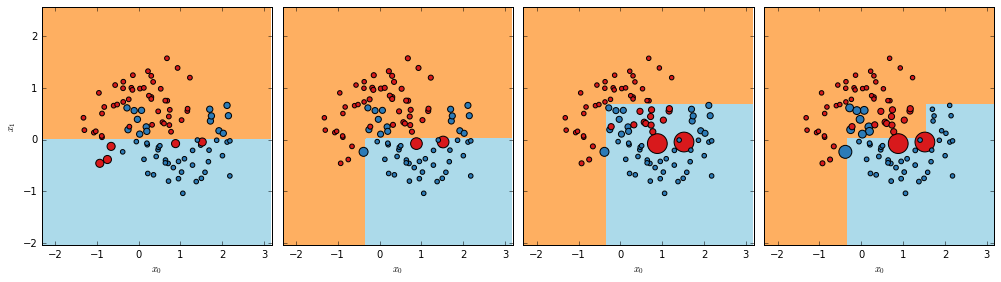

In [16]:
%run fig_code/adaboost.py

Scikit-learn provides two boosting implementations: [**AdaBoostClassifier**](http://scikit-learn.org/stable/modules/ensemble.html#adaboost) and [**GradientBoostingClassifier**](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting). The latter is a generalization of boosting to arbitrary loss functions (regression, robust regression, quantile regression, ranking, etc.).

In general, boosting algorithms require many more trees than RandomForest to get to the same level of accuracy, however, the trees that are used in boosting are usually shallow (``max_depth=3``) whereas the trees in RandomForest are deep.

## Exercise: Classifying Digits

We previously saw the **hand-written digits** data. Let's use that here to test the efficacy of the SVM and Random Forest classifiers.

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

In [18]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


To remind us what we're looking at, we'll visualize the first few data points:

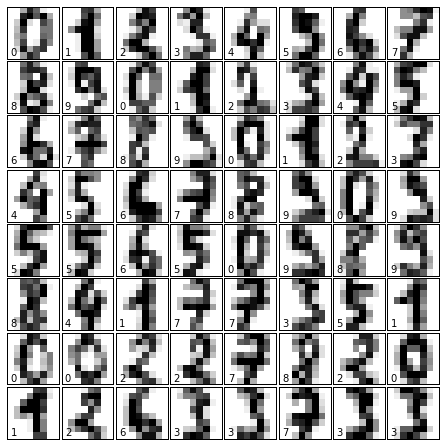

In [19]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a decision tree as follows:

F1-score: 0.6514


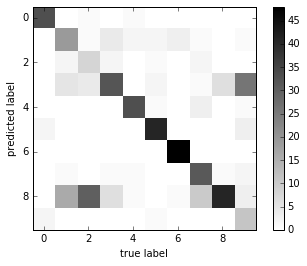

In [20]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.colorbar()
plt.xlabel("true label")
plt.ylabel("predicted label")

print('F1-score: %.4f' % metrics.f1_score(ytest, ypred))

### Exercise
1. Perform this classification task with ``sklearn.svm.SVC``. How does the choice of kernel affect the results?
2. Perform this classification task with ``sklearn.ensemble.RandomForestClassifier``.  How does ``max_features`` and ``n_estimators`` affect the results?
3. Try a few sets of parameters for each model and check the F1 score (``sklearn.metrics.f1_score``) on your results. What's the best F1 score you can reach?

In [21]:
# run this to load the solution
# %load solutions/04_svm_rf.py